# Data Import and Inicialization

In [1]:
file_path = 'airlines_delay.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import numpy as np
warnings.filterwarnings('ignore')
data = pd.read_csv(file_path)

In [3]:
# set numpy seed for reproduction
np.random.seed(42)

In [4]:
# Creating IDs (the original dataset has only flight ID, that is not unique), this is done so that the data can be preprocessed easier and to make it easier to reproduce the steps we made
data.insert(0, 'ID', data.index)

# Basic description of the data

URL: https://www.kaggle.com/datasets/ulrikthygepedersen/airlines-delay?resource=download

* Flight - Flight ID
* Time - Time of departure (minute of the day the flight departed at)
* Length - Length of Flight (in minutes)
* Airline - Airline ID
* AirportFrom - Which airport the flight flew from
* AirportTo - Which airport the flight flew to
* DayOfWeek - Day of the week of the flight
* Class - Delayed (1) or not (0)


In [5]:
data.head()

,ID,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [6]:
data.shape

(539382, 9)

Target attribute (For supervised learning): Class

Instance of interest: Instance_of_interest

Attribute of interest: Day of week / airline? (vyberte vy pro unsupervised co se vám bude více hodit)

A subset of rows of interest (For unsupervised learning): Airline = 'UA'

Cost matrix (For supervised learning)

# Data exploration

### Data types

In [7]:
print(data.dtypes)

ID               int64
Flight         float64
Time           float64
Length         float64
Airline         object
AirportFrom     object
AirportTo       object
DayOfWeek        int64
Class            int64
dtype: object


In [8]:
data["Airline"].unique()

array(['DL', 'OO', 'B6', 'US', 'FL', 'WN', 'CO', 'AA', 'YV', 'EV', 'XE',
       '9E', 'OH', 'UA', 'MQ', 'AS', 'F9', 'HA'], dtype=object)

### Checking to see whether the target class is balanced


Seems okey -> the data is split 44.54% delayed and 55.46% not delayed

In [9]:
round(len(data[data["Class"] == 1])/len(data["Class"])*100, ndigits = 2)

44.54

<Axes: >

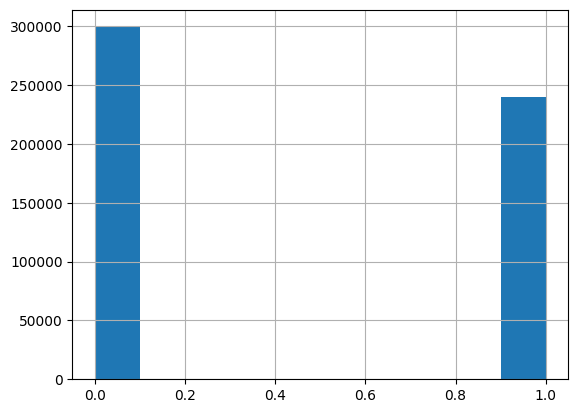

In [10]:
data["Class"].hist()

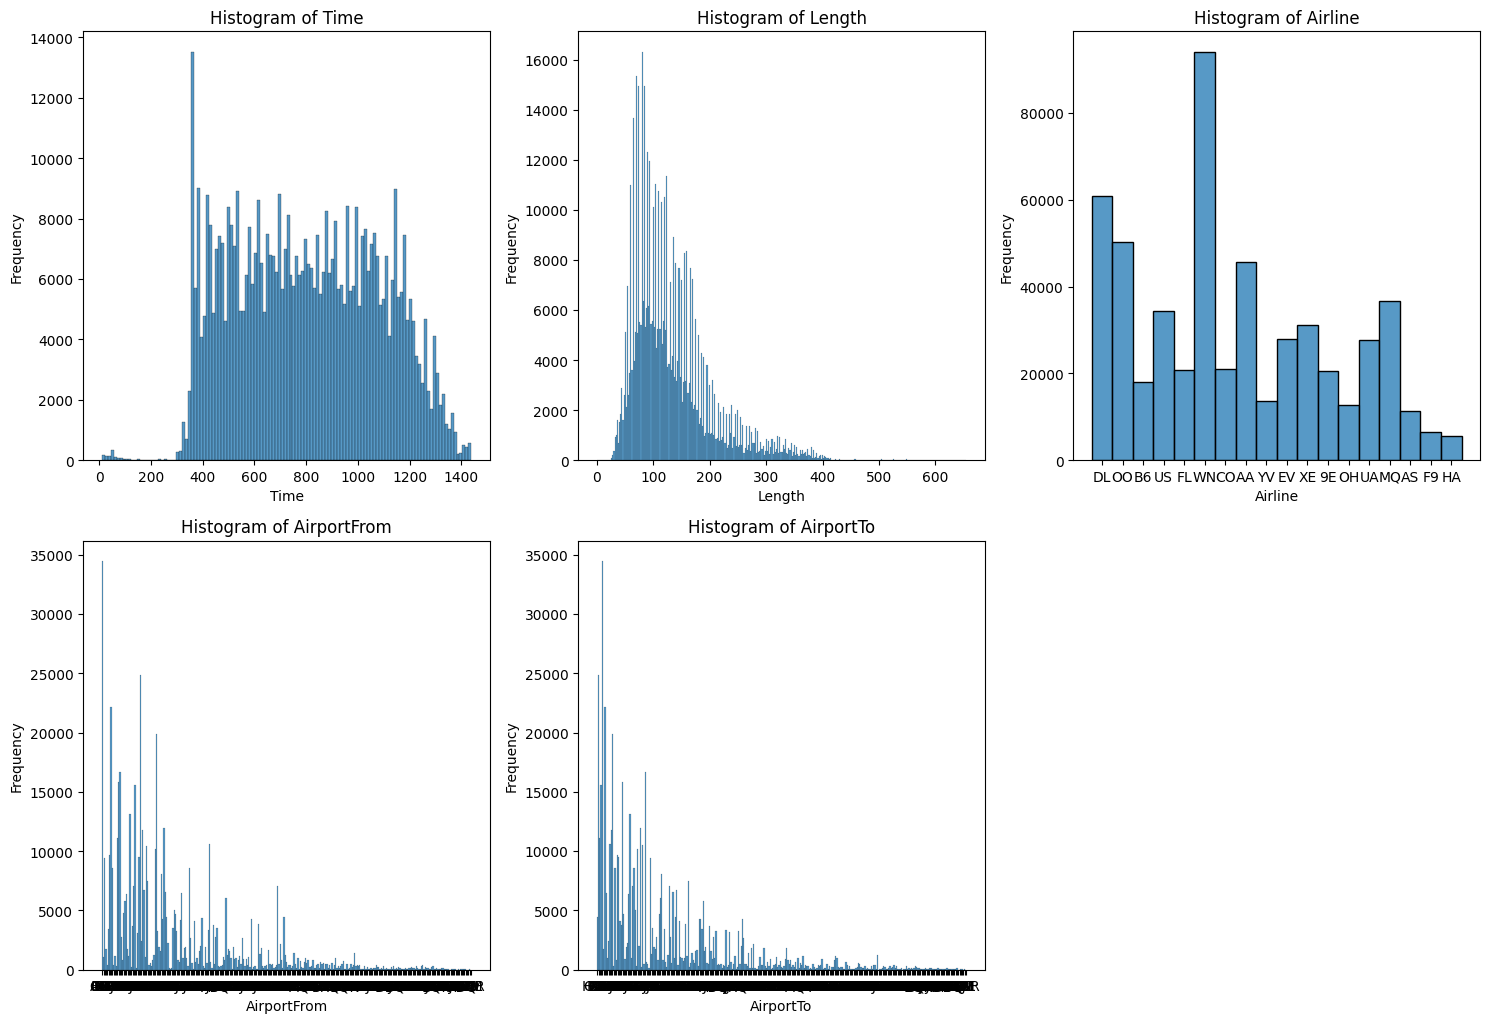

In [11]:
def plot_histograms(df, col_names):
    # Calculate the grid size
    grid_size = math.ceil(math.sqrt(len(col_names)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array

    for idx, col in enumerate(col_names):
        ax = axes[idx]
        sns.histplot(data=df, x=col, kde=False, ax=ax)
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    # Remove any unused subplots
    for idx in range(len(col_names), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()
colnames = ["Time", "Length", "Airline", "AirportFrom", "AirportTo"]
plot_histograms(data, colnames)

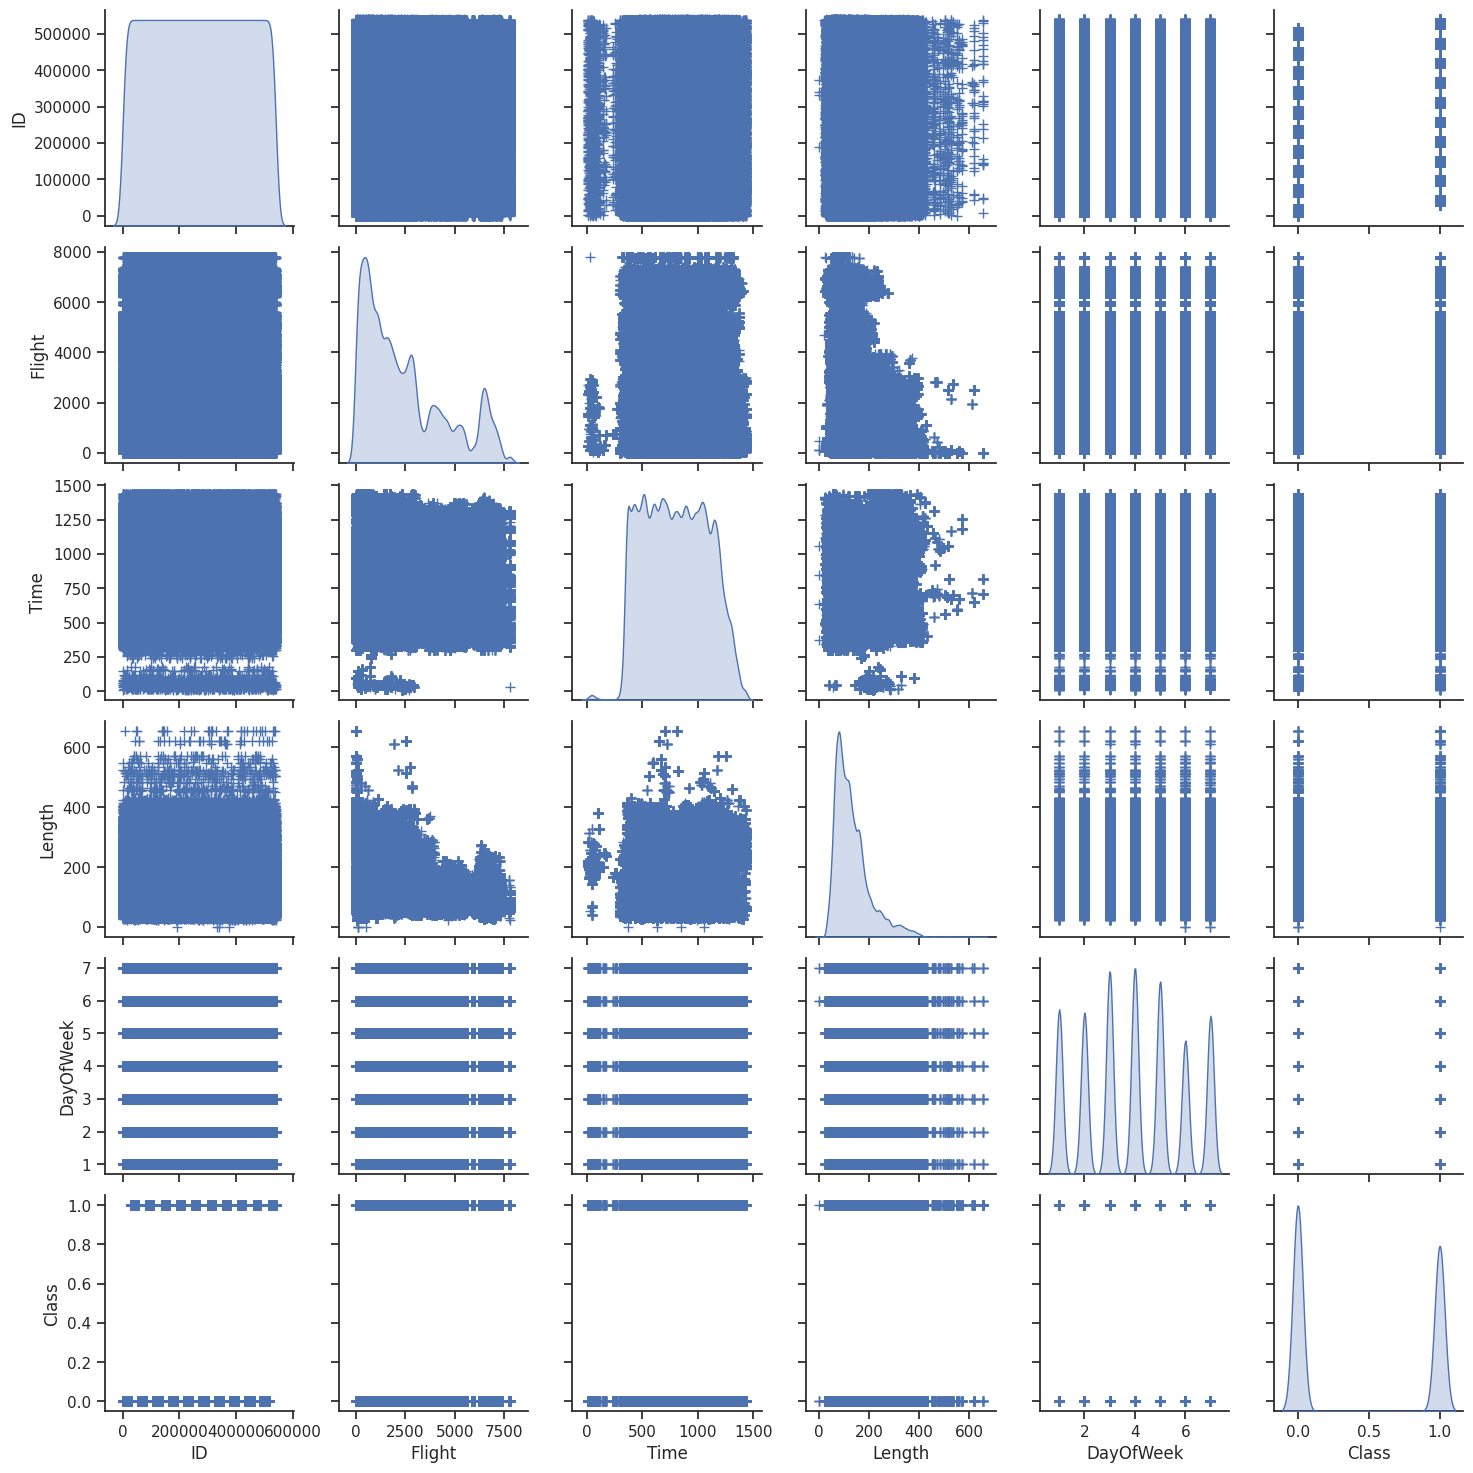

In [12]:
def plot_scatterplots(df):
    num_cols = df.select_dtypes(include=['number']).columns
    sns.set(style="ticks", color_codes=True)
    sns.pairplot(df[num_cols], diag_kind="kde", markers="+", plot_kws=dict(s=50, edgecolor="b", linewidth=1), diag_kws=dict(shade=True))
    plt.show()
plot_scatterplots(data)

Bar chart of day of week

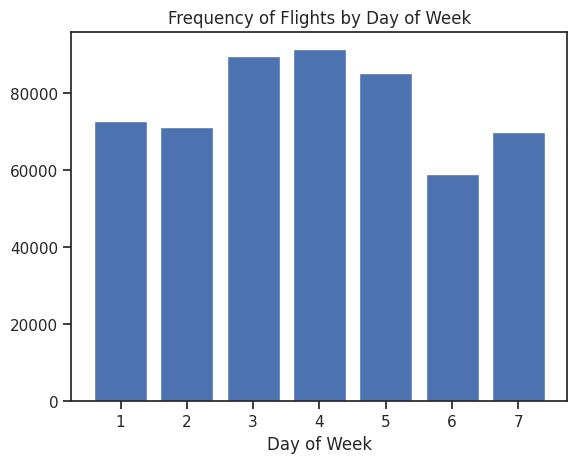

In [13]:
count = data['DayOfWeek'].value_counts()
plt.bar(count.index, count.values)
plt.xlabel('Day of Week')
plt.title('Frequency of Flights by Day of Week')
plt.show()

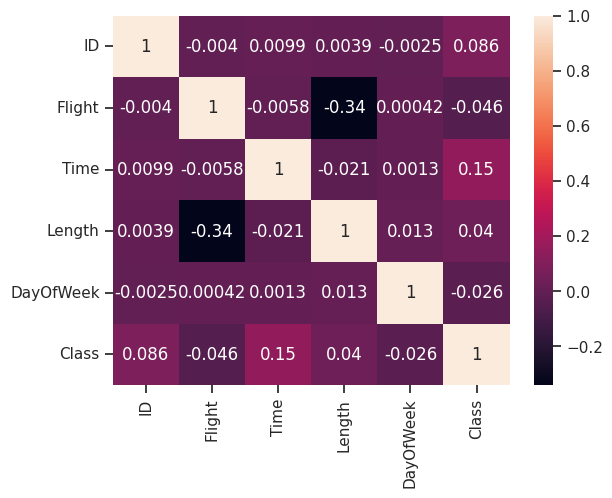

In [14]:
_ = sns.heatmap(data.iloc[:,:].corr(), annot = True)


# Supervised model

## Data preprocessing

### Preparation

We will create a new version of the DataFrame so that we do not influence the supervised part of this project negatively

In [15]:
data_supervised = data

In [16]:
data_supervised.head()

,ID,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [17]:
# importing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Deriving new columns

There migh be a connection between delays and the route itself.
Now we consider only the departure and arrival airports individualy, it might be worth looking into whether there is a conection between the often periodic routes between these cities -> we can create a new column that is the combination of AirportFrom and AriportTo

In [18]:
data_supervised["Route"] = data_supervised["AirportFrom"] + " -> " + data_supervised["AirportTo"]
data_supervised.head()

,ID,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,Route
0,0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0,ATL -> HOU
1,1,6948.0,360.0,146.0,OO,COS,ORD,4,0,COS -> ORD
2,2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0,BOS -> CLT
3,3,31.0,1410.0,344.0,US,OGG,PHX,6,0,OGG -> PHX
4,4,563.0,692.0,98.0,FL,BMI,ATL,4,0,BMI -> ATL


In [19]:
len(data_supervised["Route"].unique())

4190

We can see there are 4190 different routes in the data 

(route from A to B is different than from B to A, there migh be a relation between what side of this route you fly and whether it is delayed)

### Changing variable types

Python sklearn RandomForests and RandomTrees do not work with characters nor objects, we will need to transform all the variables into a numerical form

In [20]:
data_supervised.dtypes

ID               int64
Flight         float64
Time           float64
Length         float64
Airline         object
AirportFrom     object
AirportTo       object
DayOfWeek        int64
Class            int64
Route           object
dtype: object

We will convert the Airline, AirportFrom, AirportTo and Route variables into a numerical form

In [21]:
label_encoders = {}
for col in ['Airline', 'AirportFrom', 'AirportTo', 'Route']:
  label_encoders[col] = LabelEncoder()
  data_supervised[col] = label_encoders[col].fit_transform(data_supervised[col])

We separated these into 4 individual label_encoders to store the original categories fo we can later decode them

The code for decoding is here:

In [22]:
dict(zip(label_encoders['Airline'].classes_, range(len(label_encoders['Airline'].classes_))))
# The labelencoder took all the categories, sorted them by alphabetical order and then assigned individual numbers instead
# This code creates a dictionary of tuples,
# the first tuple element: label_encoders['Airline'].classes_ is the original categories
# the second tuple element: range(len(label_encoders['Airline'].classes_ is the numbers they are now

{'9E': 0,
 'AA': 1,
 'AS': 2,
 'B6': 3,
 'CO': 4,
 'DL': 5,
 'EV': 6,
 'F9': 7,
 'FL': 8,
 'HA': 9,
 'MQ': 10,
 'OH': 11,
 'OO': 12,
 'UA': 13,
 'US': 14,
 'WN': 15,
 'XE': 16,
 'YV': 17}

### Feature selection

We think that we do not need to remove any more atributes from the data apart from ID, just to check we can do a covariance matrix whether there is not a problem with multicolinearity (at least linear multicolinearity)

In [23]:
data_supervised = data_supervised.loc[:, [col for col in data_supervised.columns if col != "ID"]]

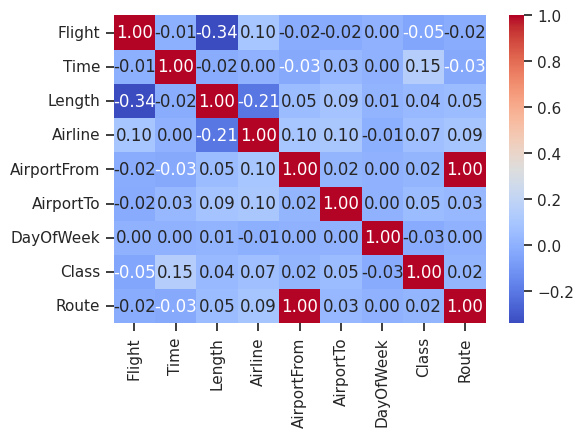

In [24]:
corr_matrix = data_supervised.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

### Test train split 


In [25]:
X = data_supervised.loc[:, [col for col in data_supervised.columns if col != "Class"]]
y = data_supervised.loc[:,["Class"]]

Large train set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
# random state for reproducibility, test size 30% train size 70%
# stratification does not need to be turned on explicitly -> the dataset is quite balanced

Small train set (for different models)

In [27]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size = 0.95, random_state = 42, stratify = y)

Datasets writing CSV datasets after preprocessing for the supervised models

In [28]:
write1 = pd.concat([X_train, y_train], ignore_index=True)
write2 = pd.concat([X_test, y_test], ignore_index=True)
write3 = pd.concat([X_train_s, y_train_s], ignore_index=True)
write4 = pd.concat([X_test_s, y_test_s], ignore_index=True)

write1.to_csv("Training70.csv", index=False)
write2.to_csv("Testing70.csv", index=False)
write3.to_csv("Training5.csv", index=False)
write4.to_csv("Testing5.csv", index=False)

### Preparation

In [29]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Modeling RandomForests and DecisionTrees


Predicting the random forest and tree with 70% data as the training set -> Runtime circa 4min

In [30]:
# Define hyperparameter grids for RandomForest and DecisionTree
rf_param_grid = {
    'n_estimators': [15, 25],  # The number of trees is not that large, by default sklearn does 100
    'max_depth': [None, 5, 10, 15, 20] # We need the model to be computed a bit faster
}

dt_param_grid = {
    'max_depth': [None, 5, 10, 15, 20]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# I had issues with reproducibility when crossvalidation was left at random, so I set up this reterministic crossvalidation parameter

# Perform GridSearchCV with 3-fold cross-validation for RandomForest and DecisionTree
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1) # n_jobs is set to -1 to use all available resources
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1) # might not do anything in colab, still worth trying

rf_grid_search.fit(X_train, y_train)
dt_grid_search.fit(X_train, y_train)

# Find the best models
best_rf = rf_grid_search.best_estimator_
best_dt = dt_grid_search.best_estimator_
print(f"best metaparameters chosen for bigdata RF: {rf_grid_search.best_params_}")
print(f"best metaparameters chosen for bigdata DT: {dt_grid_search.best_params_}")

# Make predictions for the test set
best_rf_pred = best_rf.predict(X_test)
best_dt_pred = best_dt.predict(X_test)

best metaparameters chosen for bigdata RF: {'max_depth': 15, 'n_estimators': 25}
best metaparameters chosen for bigdata DT: {'max_depth': 10}


now we model with less data (5% as training set) but more trees in the forest -> Runtime circa 1min

In [31]:
# Define hyperparameter grids for RandomForest and DecisionTree
rf_param_grid = {
    'n_estimators': [100, 200],  # The number of trees is not that large, by default sklearn does 100
    'max_depth': [5, 10, 15] # We need the model to be computed a bit faster
}

dt_param_grid = {
    'max_depth': [None, 5, 10, 15, 20]
}

# Perform GridSearchCV with 3-fold cross-validation for RandomForest and DecisionTree
rf_grid_search_s = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1) # n_jobs is set to -1 to use all available resources
dt_grid_search_s = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1) # might not do anything in colab, still worth trying

rf_grid_search_s.fit(X_train_s, y_train_s)
dt_grid_search_s.fit(X_train_s, y_train_s)

# Find the best models
best_rf_s = rf_grid_search.best_estimator_
best_dt_s = dt_grid_search.best_estimator_
print(f"best metaparameters chosen for smalldata RF: {rf_grid_search_s.best_params_}")
print(f"best metaparameters chosen for smalldata DT: {dt_grid_search_s.best_params_}")

# Make predictions for the test set
best_rf_pred_s = best_rf_s.predict(X_test_s)
best_dt_pred_s = best_dt_s.predict(X_test_s)

best metaparameters chosen for smalldata RF: {'max_depth': 10, 'n_estimators': 200}
best metaparameters chosen for smalldata DT: {'max_depth': 5}


Note that the metaparameters chosen were always more trees in the random forest

Another thins that is interesting is that the models chose differing max_depths

## Evaluation

We have created 4 models in total, 2 random forests and 2 decision trees, once with 70% training data and the second time with just 5% of the data

### Accuracy

My dataset is quite balanced -> Better to use Accuracy than F-score

In [32]:
print("Accuracy Score Random forest 70% : ", round(accuracy_score(y_test,best_rf_pred)*100,2),'%')
print("Accuracy Score Decision tree 70% : ", round(accuracy_score(y_test,best_dt_pred)*100,2),'%')
print("Accuracy Score Random forest 5% : ", round(accuracy_score(y_test_s,best_rf_pred_s)*100,2),'%')
print("Accuracy Score Decision tree 5% : ", round(accuracy_score(y_test_s,best_dt_pred_s)*100,2),'%')

Accuracy Score Random forest 70% :  66.46 %
Accuracy Score Decision tree 70% :  64.7 %
Accuracy Score Random forest 5% :  69.95 %
Accuracy Score Decision tree 5% :  65.27 %


Important to note here is that were we were able to beat a uniform classifier that would always pick not delayed (circa 56%) 

I consider this a great sucess

### Other metrics (ROC, classification report)

#### Classification report

Classification report summarizes all the important parameters of these models

To interpret:
 
0 and 1 are the classes (not delayed and delayed respectively)

the bottom rows are averages of the above

In [33]:
print("RandomForest 70% Classification Report:")
print(classification_report(y_test, best_rf_pred))

RandomForest 70% Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.80      0.73     89736
           1       0.67      0.49      0.57     72079

    accuracy                           0.66    161815
   macro avg       0.67      0.65      0.65    161815
weighted avg       0.67      0.66      0.66    161815



In [34]:
print("DecisionTree 70% Classification Report:")
print(classification_report(y_test, best_dt_pred))

DecisionTree 70% Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.80      0.72     89736
           1       0.65      0.46      0.54     72079

    accuracy                           0.65    161815
   macro avg       0.65      0.63      0.63    161815
weighted avg       0.65      0.65      0.64    161815



In [35]:
print("RandomForest 5% Classification Report:")
print(classification_report(y_test_s, best_rf_pred_s))

RandomForest 5% Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.83      0.75    284162
           1       0.72      0.53      0.61    228251

    accuracy                           0.70    512413
   macro avg       0.70      0.68      0.68    512413
weighted avg       0.70      0.70      0.69    512413



In [36]:
print("DecisionTree 70% Classification Report:")
print(classification_report(y_test_s, best_dt_pred_s))

DecisionTree 70% Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72    284162
           1       0.66      0.46      0.54    228251

    accuracy                           0.65    512413
   macro avg       0.65      0.63      0.63    512413
weighted avg       0.65      0.65      0.64    512413



#### ROC curve (+ Area under the curve)

Random Forest ROC AUC: 0.7154491690774002
Decision Tree ROC AUC: 0.6929424069080603
Random Forest ROC AUC: 0.7690015304891002
Decision Tree ROC AUC: 0.7025494289247727


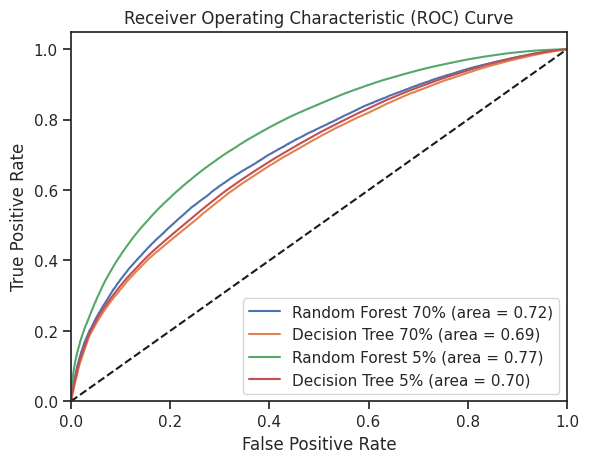

In [37]:
# Make predictions for the test set using predicted probabilities
best_rf_pred_proba = best_rf.predict_proba(X_test)[:, 1] # Probability of the positive class
best_dt_pred_proba = best_dt.predict_proba(X_test)[:, 1]
best_rf_pred_proba_s = best_rf_s.predict_proba(X_test_s)[:, 1]
best_dt_pred_proba_s = best_dt_s.predict_proba(X_test_s)[:, 1]

# Compute ROC AUC scores
rf_roc_auc = roc_auc_score(y_test, best_rf_pred_proba)
dt_roc_auc = roc_auc_score(y_test, best_dt_pred_proba)
rf_roc_auc_s = roc_auc_score(y_test_s, best_rf_pred_proba_s)
dt_roc_auc_s = roc_auc_score(y_test_s, best_dt_pred_proba_s)

print(f"Random Forest ROC AUC: {rf_roc_auc}")
print(f"Decision Tree ROC AUC: {dt_roc_auc}")
print(f"Random Forest ROC AUC: {rf_roc_auc_s}")
print(f"Decision Tree ROC AUC: {dt_roc_auc_s}")

# Compute ROC curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, best_rf_pred_proba)
dt_fpr, dt_tpr, _ = roc_curve(y_test, best_dt_pred_proba)
rf_fpr_s, rf_tpr_s, _ = roc_curve(y_test_s, best_rf_pred_proba_s)
dt_fpr_s, dt_tpr_s, _ = roc_curve(y_test_s, best_dt_pred_proba_s)

# Plot ROC curves
plt.figure()
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest 70% (area = {rf_roc_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree 70% (area = {dt_roc_auc:.2f})')
plt.plot(rf_fpr_s, rf_tpr_s, label=f'Random Forest 5% (area = {rf_roc_auc_s:.2f})')
plt.plot(dt_fpr_s, dt_tpr_s, label=f'Decision Tree 5% (area = {dt_roc_auc_s:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The RandomForest model that used only 5% os the data is clearly much superior to the others

My guess is that it is thanks to the metaparameters (namely number of trees) being bigger

The results migh be a bit biassed because the 1st set of models is tested on 30% of the data and the other set on 95% of the data

This should be okey though because overall the models were trained and tested on stratified samples for y_test and both were tested and trained on stupendous amounts of data...

### Using the cost matrix (On the best model)

The cost of wrongly predicting that a plane will not be delayed but in fact ends up being delayed (Type 2 error == FN) is much higher than the opposite

Kind of stupid that the Type 2 error is more costly, but still

cost matrix:

**[TP, FP,**

**FN, TN]**


**[0, 1,**

**5, 0]**

In [38]:
def cost_function(y_true, y_probs, threshold, cost_matrix):
    y_pred = (y_probs >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    
    TP, FP, FN, TN = cm[1, 1], cm[0, 1], cm[1, 0], cm[0, 0]
    cost = cost_matrix[0] * TP + cost_matrix[1] * FP + cost_matrix[2] * FN + cost_matrix[3] * TN
    return cost

# Set the cost matrix
cost_matrix = [0, 1, 5, 0]

# Calculate costs for different thresholds
thresholds = np.linspace(0, 1, 100)
costs = [cost_function(y_test_s, best_rf_pred_proba_s, threshold, cost_matrix) for threshold in thresholds]

# Find the optimal threshold and minimum cost
optimal_threshold = thresholds[np.argmin(costs)]
min_cost = np.min(costs)

print(f"Optimal threshold: {optimal_threshold:.2f}, Minimum cost: {min_cost}")


Optimal threshold: 0.23, Minimum cost: 260332


## Explanation

Important to note is that for the explanation we kept the 5% models, since they clearly beat the 70% ones

### The most important variables

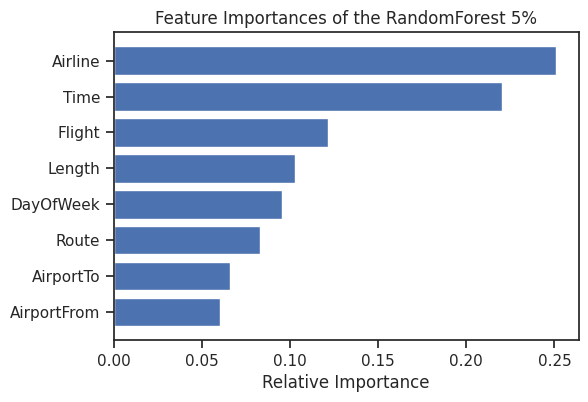

In [39]:
features = X_train_s.columns
indices = np.argsort(best_rf_s.feature_importances_)
plt.figure(figsize=(6, 4))
plt.title(f"Feature Importances of the RandomForest 5%")
plt.barh(range(len(indices)), best_rf_s.feature_importances_[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

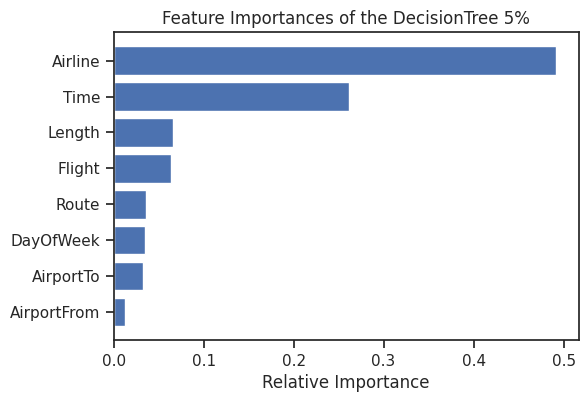

In [40]:
indices = np.argsort(best_dt_s.feature_importances_)
plt.figure(figsize=(6, 4))
plt.title(f"Feature Importances of the DecisionTree 5%")
plt.barh(range(len(indices)), best_dt_s.feature_importances_[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Visualizing the models

Note that for the random model we chose the first tree, since there is not a unified tree to plot -> the decisions on instances are passed by majority vote across the trees

Another thing is that we had to set the max_depth parameter to some arbitrary number otherwise google colab would comit suicide (and this makes only the most important features visible anyway)

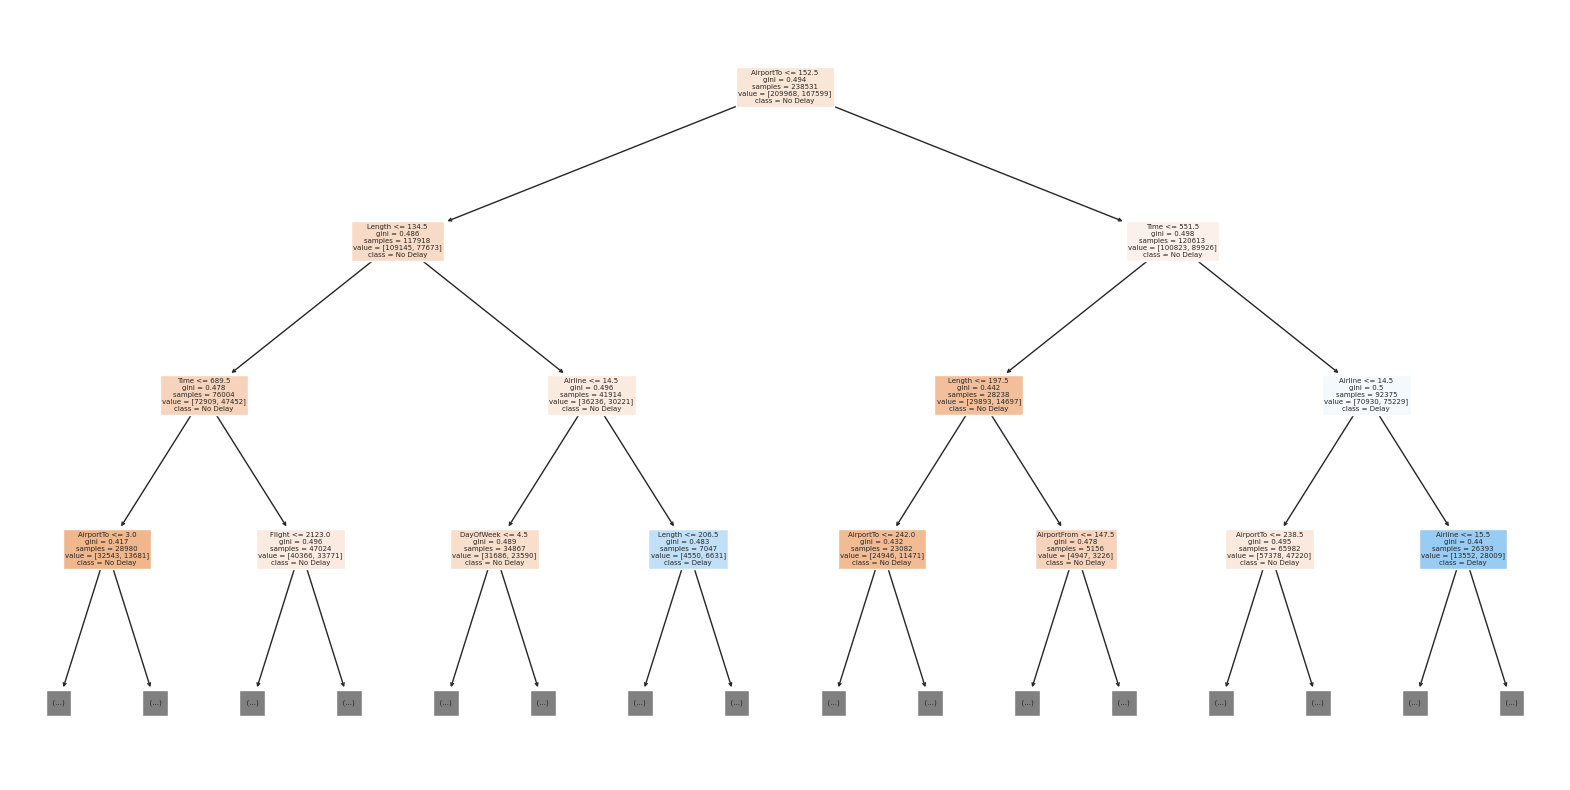

In [41]:
# Plot a single tree from the RandomForest model
plt.figure(figsize=(20, 10))
single_tree = best_rf_s.estimators_[0]  # Choose the first tree from the RandomForest
plot_tree(single_tree, feature_names=features, class_names=['No Delay', 'Delay'], filled=True, max_depth = 3)
plt.show()

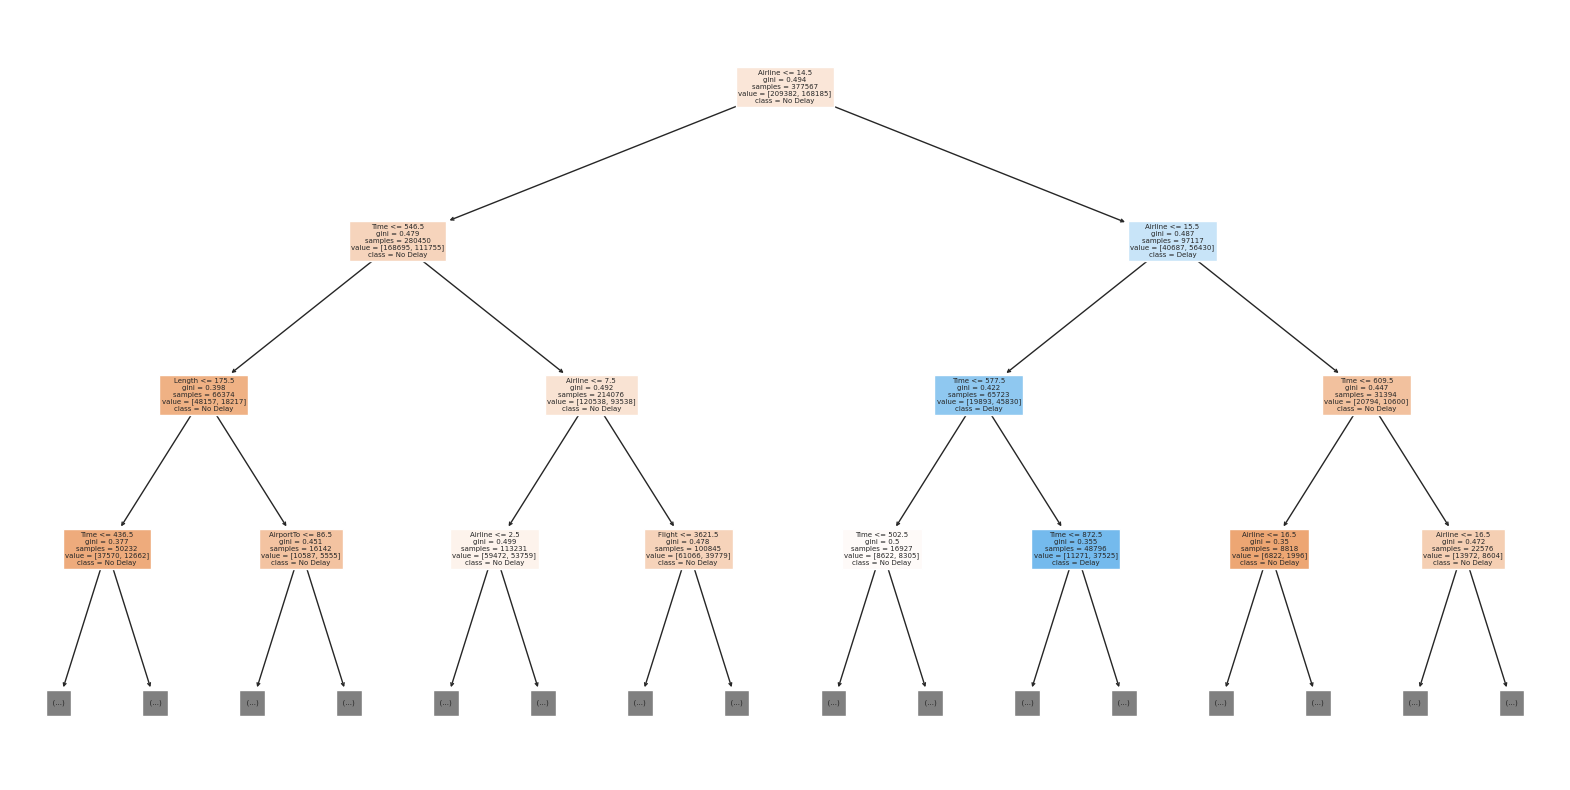

In [42]:
# Plot the entire DecisionTree model
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=features, class_names=['No Delay', 'Delay'], filled=True, max_depth = 3)
plt.show()


### Predicting the chosen instance

The instance is stored in: Instance_of_interest

In [43]:
Instance_of_interest = data.loc[data["Length"].idxmax()]
Instance_of_interest["Length"] 
Instance_of_interest = data[data["Length"] == Instance_of_interest["Length"]]
Instance_of_interest = Instance_of_interest.iloc[0]
Instance_of_interest = pd.DataFrame(Instance_of_interest)
Instance_of_interest

,7990
ID,7990.0
Flight,15.0
Time,710.0
Length,655.0
Airline,4.0
AirportFrom,96.0
AirportTo,128.0
DayOfWeek,4.0
Class,0.0
Route,1405.0


In [44]:
Instance_of_interest = {'Flight': 15.0,
                        'Time': 710.0,
                        'Length': 655.0,
                        'Airline': 4.0,
                        'AirportFrom': 96.0,
                        'AirportTo': 128.0,
                        'DayOfWeek': 4,
                        'Route': 1405.0}
Instance_of_interest = pd.DataFrame([Instance_of_interest])

In [45]:
# Now we try to predict the Class by both models:
prediction_rf = best_rf_s.predict(Instance_of_interest)
prediction_dt = best_dt_s.predict(Instance_of_interest)

predicted_value_rf = prediction_rf[0]
predicted_value_dt = prediction_dt[0]
# Print the predicted value
print("Predicted value for the RandomForest:", predicted_value_rf)
print("Predicted value for the DecisionTree:", predicted_value_dt)

Predicted value for the RandomForest: 1
Predicted value for the DecisionTree: 1


As we can see both of the models classify the chosen isntance wrongly == as delayed even though it is not

In [46]:
predicted_probability = best_rf_s.predict_proba(Instance_of_interest)
probability_of_delay = predicted_probability[0][1]
probability_of_delay

0.7395985115421664

In [47]:
predicted_probability = best_dt_s.predict_proba(Instance_of_interest)
probability_of_delay = predicted_probability[0][1]
probability_of_delay

0.7033743133664662

From these predicted probabilities we can see that the models come nowhere close to predicting this instance correctly, especialy when we consider that based on the cost matrix the best would be to choose a threshold of 0.23

# Unsupervised model

This part covers the unsupervised methods. We will use k-means and hierarchical clustering to identify similar flights.

In [48]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans

### Data preprocessing

To filter the data set (as per the assignment), we will only cluster flights which have flown with the airline 'UA'.

In [49]:
data = pd.read_csv(file_path)
data = data.loc[data['Airline'] == 'UA'].reset_index()
data

,index,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,25,969.0,971.0,46.0,UA,STT,SJU,6,0
1,31,663.0,502.0,254.0,UA,DCA,DEN,5,0
2,37,536.0,421.0,132.0,UA,ORD,LGA,1,0
3,40,593.0,1071.0,289.0,UA,BOS,DEN,5,0
4,42,152.0,1134.0,257.0,UA,SFO,ORD,7,0
...,...,...,...,...,...,...,...,...,...
27614,539234,244.0,617.0,143.0,UA,DEN,ORD,1,1
27615,539288,191.0,691.0,178.0,UA,MCO,ORD,1,1
27616,539307,648.0,602.0,181.0,UA,DEN,PIT,5,1
27617,539320,209.0,885.0,351.0,UA,IAD,LAX,3,1


Because we want to use k-means and hierarchical clustering, we need to consider only variables which are numerical. Unfortunatelly, our data set has only two of those - Time of the flight and Length of the flight. All clustering methods are hence done only on these two columns.

In [50]:
data_cluster = data.loc[:, ["Time", "Length"]]
data_cluster

,Time,Length
0,971.0,46.0
1,502.0,254.0
2,421.0,132.0
3,1071.0,289.0
4,1134.0,257.0
...,...,...
27614,617.0,143.0
27615,691.0,178.0
27616,602.0,181.0
27617,885.0,351.0


As both Time and Length have different units and variance, they both need to be standardized.

In [51]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data_cluster))
scaled_data

,0,1
0,0.591426,-1.583764
1,-1.009559,0.706725
2,-1.286062,-0.636735
3,0.932788,1.092143
4,1.147845,0.739761
...,...,...
27614,-0.616993,-0.515603
27615,-0.364386,-0.130185
27616,-0.668198,-0.097149
27617,0.297855,1.774885


The transformed data have - as expected - zero mean and standard deviation equal to one.

In [52]:
scaled_data.describe()

,0,1
count,2.761900e+04,2.761900e+04
mean,-1.811152e-16,-6.740367e-17
std,1.000018e+00,1.000018e+00
min,-1.593287e+00,-1.594776e+00
25%,-9.173914e-01,-7.798907e-01
50%,-5.716058e-02,-3.614360e-01
75%,8.440336e-01,7.177366e-01
max,2.188998e+00,3.977278e+00


Now we export the preprocessed dataset for submission

In [53]:
scaled_data.to_csv("Unsupervised_preprocessed.csv", index=False)

### Modelling

#### K-means clustering

First, we will focus on clustering using the k-means method. This method requires us to pick the number of clusters and the algorithm to use. We will use for loops with different hyperparameters to find the optimal number of clusters and the optimal method. Note that the range for possible clusters is <1, 10> and algorithms we will consider are 'elkan' and 'lloyd'.

In [54]:
rep = range(1, 11)
inertia_l = list()
algorithms = ["elkan", "lloyd"]

np.random.seed(789)
for i in rep:
  for a in algorithms:
    kmeans = KMeans(n_clusters=i, algorithm=a)
    kmeans.fit(scaled_data)
    inertia_l.append(kmeans.inertia_)

The final inertias are then joined with the algorithm type in a signle pandas DataFrame.

In [55]:
n_clusters = list(rep)*2
n_clusters.sort()
algorithms_all = algorithms*10

df_inertia = pd.DataFrame({'Number of clusters': n_clusters,
                   'Algorithm used': algorithms_all, 
                   'Inertia score': inertia_l})

df_inertia = df_inertia.sort_values(by = ['Inertia score'])
print(df_inertia)

    Number of clusters Algorithm used  Inertia score
18                  10          elkan    5223.869916
19                  10          lloyd    5226.245132
17                   9          lloyd    5751.023296
16                   9          elkan    5751.116140
15                   8          lloyd    6521.023600
14                   8          elkan    6521.302605
12                   7          elkan    7530.910170
13                   7          lloyd    7531.052582
10                   6          elkan    8770.378576
11                   6          lloyd    8785.740332
8                    5          elkan   10539.942084
9                    5          lloyd   10540.832915
7                    4          lloyd   13066.798176
6                    4          elkan   13066.853798
5                    3          lloyd   19480.001853
4                    3          elkan   19480.001853
3                    2          lloyd   33826.930111
2                    2          elkan   33827.

 Results are visualized using an elbow charts for both algorithms.

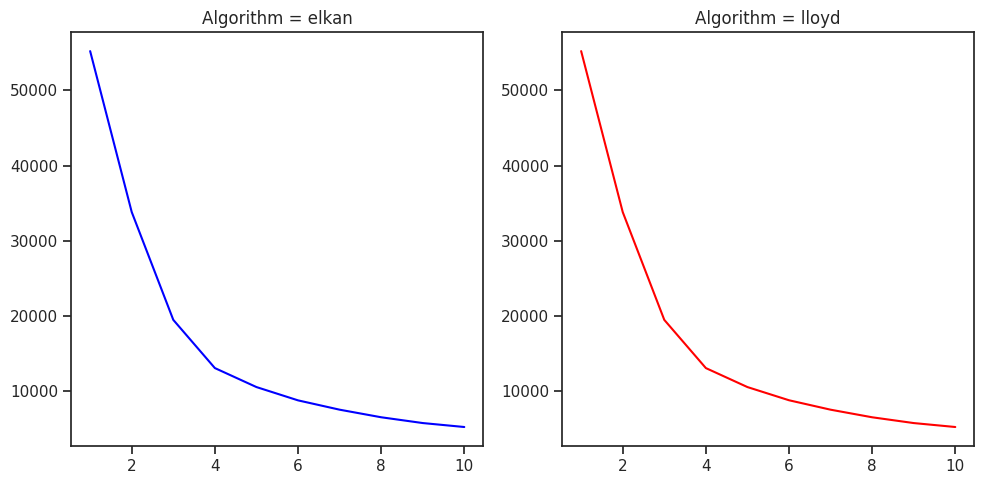

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the first graph in the first subplot
y = df_inertia.loc[df_inertia['Algorithm used'] == 'elkan']
axs[0].plot(y['Number of clusters'], y['Inertia score'], color='blue')
axs[0].set_title('Algorithm = elkan')

# plot the second graph in the second subplot
y = df_inertia.loc[df_inertia['Algorithm used'] == 'lloyd']
axs[1].plot(y['Number of clusters'], y['Inertia score'], color='red')
axs[1].set_title('Algorithm = lloyd')

# adjust the layout of the subplots
fig.tight_layout()

# display the figure
plt.show()

We see that the algorithms perform very similarly and it might be not as important as we thought. We will continue with the 'elkan' algorithm. It looks like the 'elbow' for clusters is in k = 3 or k = 4. We will continue with k = 4.

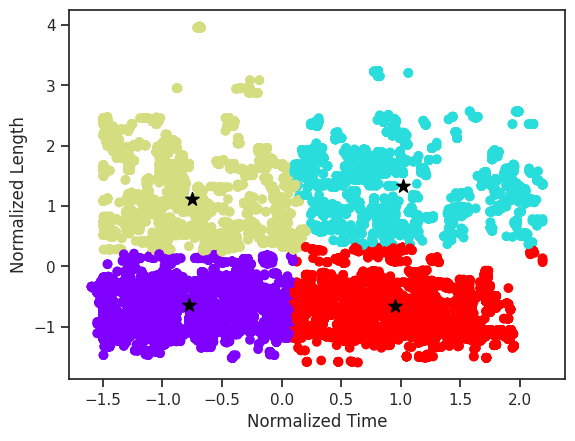

In [57]:
np.random.seed(456)
kmeans = KMeans(n_clusters=4, algorithm="elkan")
kmeans.fit(scaled_data)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

plt.scatter(scaled_data.iloc[:, 0], scaled_data.iloc[:, 1], c=labels, cmap='rainbow')
plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=100, c='black')
plt.xlabel("Normalized Time")
plt.ylabel("Normalized Length")
plt.show()

We see that the data is nice split into four distinct clusters. Our advantage is that we only have two variables that are being clustered so we can display our results in a 2d space without any loss in the data variability.

We can also look at the clusters regards to which flights have been delayed.

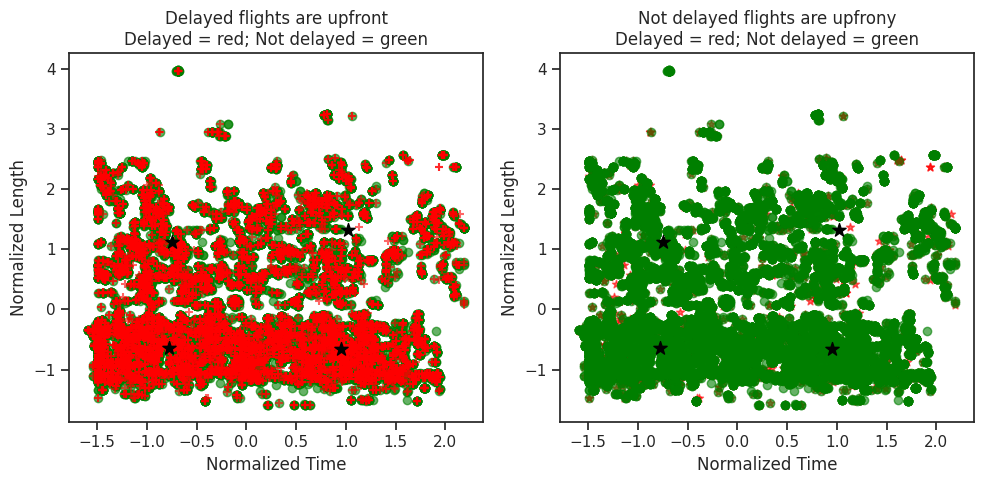

In [59]:
delayed = data.loc[data['Class'] == 0].index
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Delayed first
axs[0].scatter(x = scaled_data.iloc[-delayed, 0],
               y = scaled_data.iloc[-delayed, 1],
               c = "green", marker = "o", alpha = .6)
axs[0].scatter(x = scaled_data.iloc[delayed, 0],
               y = scaled_data.iloc[delayed, 1],
               c = "red", marker = "+", alpha = .6)
axs[0].scatter(centers[:, 0], centers[:, 1], marker='*', s=100, c='black')
axs[0].set_xlabel("Normalized Time")
axs[0].set_ylabel("Normalized Length")
axs[0].set_title('Delayed flights are upfront\nDelayed = red; Not delayed = green')

# Not delayed first
axs[1].scatter(x = scaled_data.iloc[delayed, 0],
               y = scaled_data.iloc[delayed, 1],
               c = "red", marker = "*", alpha = .6)
axs[1].scatter(x = scaled_data.iloc[-delayed, 0],
               y = scaled_data.iloc[-delayed, 1],
               c = "green", marker = "o", alpha = .6)
axs[1].scatter(centers[:, 0], centers[:, 1], marker='*', s=100, c='black')
axs[1].set_xlabel("Normalized Time")
axs[1].set_ylabel("Normalized Length")
axs[1].set_title('Not delayed flights are upfrony\nDelayed = red; Not delayed = green')

# adjust the layout of the subplots
fig.tight_layout()

# display the figure
plt.show()

In [60]:
delayed

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            26675, 26676, 26677, 26678, 26679, 26680, 26681, 26682, 26683,
            26684],
           dtype='int64', length=18673)

We can see that the there is no pattern in the data and there are no 'natural' clusters that could be used. K-means hence did not show any patterns or groups for flights that could be delayed.

## Hierarchical clustering

The second approach we will consider is hierarchical clustering. We decided to use complete, average and single clustering. There is more options though, for example centroid linkage and clustering based on Ward's criterion.

In [61]:
np.random.seed(159)
complete_clustering = linkage(scaled_data, method="complete", metric="euclidean")
average_clustering = linkage(scaled_data, method="average", metric="euclidean")
single_clustering = linkage(scaled_data, method="single", metric="euclidean")

##### Complete clustering

Firsty we used complete clustering - we compute the maximum distance between clusters, then merge the closest ones. 

If we were to merge cluster 1 and 2 into a new cluster 1&2 and then try to calculate the distance between cluster 3 and the new cluster 1&2, we would look at the distance between 1-3 and 2-3 and used the bigger distance as the distance between 1&2-3.

We only use euclidian distanes in all linkage methods. Below is a full dendrogram showing all possible clusters.

(note that the code .plot() runs for approximately 7 mins)

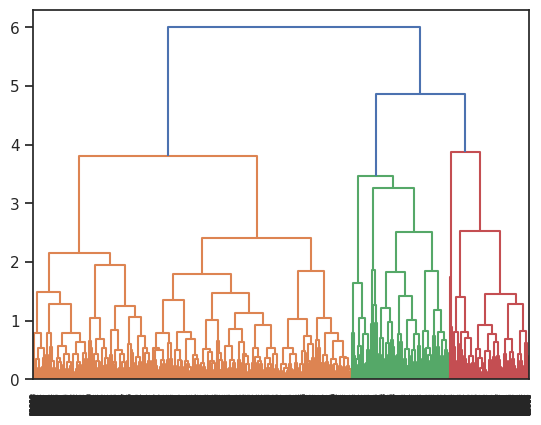

In [62]:
dendrogram(complete_clustering)
plt.show()

Let's also look at the last 4 record of the distance matrix.

In [63]:
complete_clustering[-4:]

array([[5.52270000e+04, 5.52280000e+04, 3.79812260e+00, 1.77800000e+04],
       [5.52200000e+04, 5.52300000e+04, 3.87700674e+00, 4.41700000e+03],
       [5.52320000e+04, 5.52340000e+04, 4.85622275e+00, 9.83900000e+03],
       [5.52330000e+04, 5.52350000e+04, 6.00023815e+00, 2.76190000e+04]])

Based on the distance measured within the dendrogram, the optimal number
of clusters is 3.

In [64]:
max(set(fcluster(complete_clustering, 4, criterion='distance')))

3

Here is a smaller dendrogram cut at k = 12.

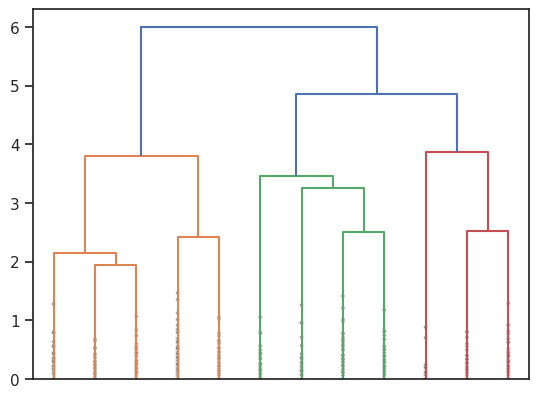

In [65]:
dendrogram(
    complete_clustering,
    truncate_mode='lastp',  
    p=12, 
    show_leaf_counts=False, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True, 
)
plt.show()

The final step is to calculate the total within sum of squares.

In [66]:
k = 3
labels = fcluster(complete_clustering, k, criterion='maxclust')
wss = 0
for i in range(1, k+1):
    cluster_points = scaled_data[labels == i]
    cluster_center = cluster_points.mean(axis=0)
    wss += ((cluster_points - cluster_center) ** 2).sum()
    print(f"{i}:=> {wss.sum()}")

1:=> 19980.778959875617
2:=> 24502.79331089792
3:=> 27039.247223174636


##### Average clustering

Then we used average clustering - we compute average distance between clusters and then merge the closest ones.

If we were to merge cluster 1 and 2 into a new cluster 1&2 and then try to calculate the distance between cluster 3 and the new cluster 1&2, we would calculate the average distance between all points in cluster 1&2 and all points in cluster 3, which would give us the distance between the new cluster 1&2 and cluster 3 in the average-linkage clustering method.

(note that the code .plot() runs for approximately 7 mins)

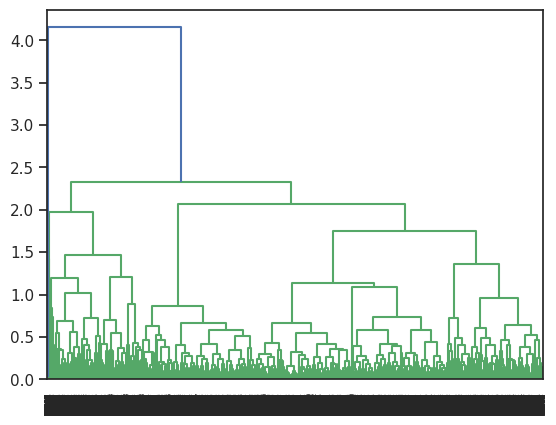

In [67]:
dendrogram(average_clustering)
plt.show()

Let's also look at the last 4 record of the distance matrix.

In [68]:
average_clustering[-4:]

array([[5.52300000e+04, 5.52310000e+04, 1.96798179e+00, 5.24500000e+03],
       [5.52210000e+04, 5.52320000e+04, 2.07285838e+00, 2.23370000e+04],
       [5.52330000e+04, 5.52340000e+04, 2.32241012e+00, 2.75820000e+04],
       [5.23860000e+04, 5.52350000e+04, 4.15254168e+00, 2.76190000e+04]])

Based on the distance measured within the dendrogram, the optimal number
of clusters is 4.

In [69]:
max(set(fcluster(average_clustering, 2, criterion='distance')))

4

For clusters created using the average metric, the optimal number of clusters is 3 as well. Note that the maximum distance in the fcluster call had to be adjusted. If the maximum distance is too high, the optimal number of clusters would be in our case always 1.

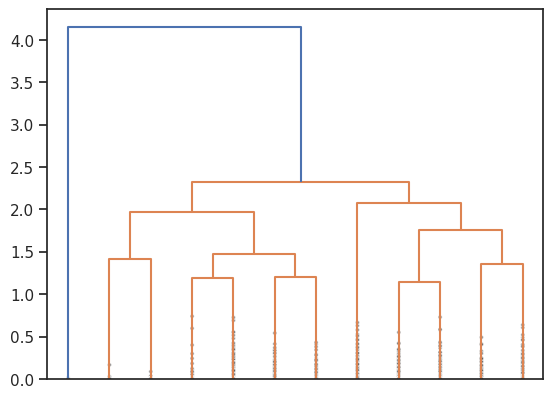

In [70]:
dendrogram(
    average_clustering,
    truncate_mode='lastp',  
    p=12, 
    show_leaf_counts=False, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True, 
)
plt.show()

Calculation of sum of squares

In [71]:
k = 3
labels = fcluster(average_clustering, k, criterion='maxclust')
wss = 0
for i in range(1, k+1):
    cluster_points = scaled_data[labels == i]
    cluster_center = cluster_points.mean(axis=0)
    wss += ((cluster_points - cluster_center) ** 2).sum()
    print(f"{i}:=> {wss.sum()}")

1:=> 0.002983920521025114
2:=> 4589.152386396949
3:=> 39482.8543522961


##### Single clustering

In the end we used single linkage - we computed the distances in the same fashion as in the complete linkage, only using the smallest distance. Then we merged the closest clusters.

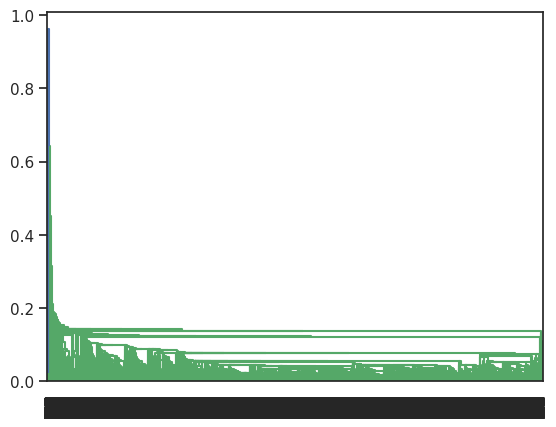

In [72]:
dendrogram(single_clustering)
plt.show()

Let's also look at the last 4 record of the distance matrix.

In [73]:
single_clustering[-4:]

array([[5.52000000e+04, 5.52320000e+04, 4.50646863e-01, 2.75410000e+04],
       [5.02290000e+04, 5.52330000e+04, 4.91683807e-01, 2.75450000e+04],
       [5.52310000e+04, 5.52340000e+04, 6.42704329e-01, 2.75820000e+04],
       [5.30690000e+04, 5.52350000e+04, 9.61563572e-01, 2.76190000e+04]])

Interestingly, based on the distance measured within the dendrogram, the optimal number of clusters is 1.

In [74]:
max(set(fcluster(single_clustering, 1, criterion='distance')))

1

The single clustering method suggests that the optimal number of clusters is 1 no matter the maximum distance.

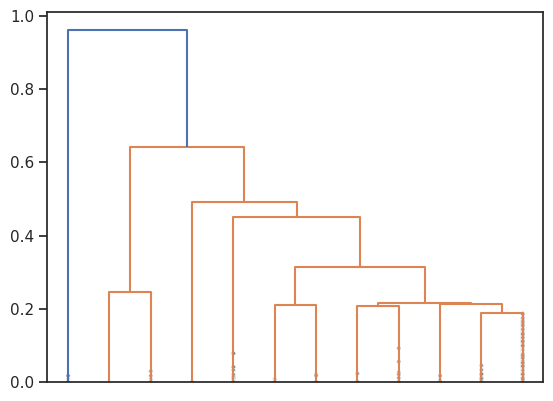

In [75]:
dendrogram(
    single_clustering,
    truncate_mode='lastp',  
    p=12, 
    show_leaf_counts=False, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True, 
)
plt.show()

Calculation of within sum of squares

In [76]:
k = 1
labels = fcluster(single_clustering, k, criterion='maxclust')
wss = 0
for i in range(1, k+1):
    cluster_points = scaled_data[labels == i]
    cluster_center = cluster_points.mean(axis=0)
    wss += ((cluster_points - cluster_center) ** 2).sum()
    print(f"{i}:=> {wss.sum()}")

1:=> 55238.0


# Modelling evaluation

| Type                    | Specification       | Best k | Inertia/WSS |
| ----------------------- | ------------------- | ------ | ----------- |
| K-means clustering      | Alkan algorhitm     | 4      | 13 066      |
| Hierarchical clustering | Complete clustering | 3      | 27 039      | 
| Hierarchical clustering | Average clustering  | 3      | 39 482      |
| Hierarchical clustering | Single clustering   | 1      | 55 238      |

Based on the overview table, the K-means algorithm produced the best division of data. The second best is Hierarchical clustering with method complete.